# 01 — Data Exploration

Explore the Kaggle push-up dataset: video inventory, metadata statistics, label distribution, and sample frames.

In [7]:
import sys
sys.path.insert(0, "..")

from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

plt.rcParams["figure.dpi"] = 120
plt.rcParams["figure.figsize"] = (10, 6)

DATA_DIR = Path("../data/raw/kaggle_pushups")

## 1. Dataset Inventory

Count videos by category and display a bar chart.

Correct videos: 50
Incorrect videos: 50
Total: 100


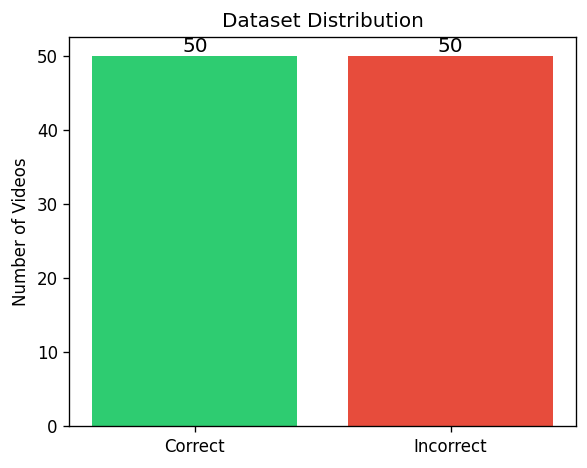

In [8]:
correct_dir = DATA_DIR / "Correct sequence"
wrong_dir = DATA_DIR / "Wrong sequence"

correct_videos = sorted(correct_dir.glob("*.mp4"))
wrong_videos = sorted(wrong_dir.glob("*.mp4"))
all_videos = correct_videos + wrong_videos

print(f"Correct videos: {len(correct_videos)}")
print(f"Incorrect videos: {len(wrong_videos)}")
print(f"Total: {len(all_videos)}")

fig, ax = plt.subplots(figsize=(5, 4))
counts = [len(correct_videos), len(wrong_videos)]
bars = ax.bar(["Correct", "Incorrect"], counts, color=["#2ecc71", "#e74c3c"])
ax.bar_label(bars, fontsize=12)
ax.set_ylabel("Number of Videos")
ax.set_title("Dataset Distribution")
plt.tight_layout()
plt.show()

## 2. Video Metadata

Extract FPS, resolution, duration, and frame count from every video.

In [9]:
records = []
for vpath in all_videos:
    cap = cv2.VideoCapture(str(vpath))
    fps = cap.get(cv2.CAP_PROP_FPS) or 0
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    cap.release()
    label = "correct" if vpath.parent.name.startswith("Correct") else "incorrect"
    records.append({
        "file": vpath.name,
        "label": label,
        "fps": fps,
        "width": w,
        "height": h,
        "n_frames": n_frames,
        "duration_s": round(n_frames / fps, 2) if fps > 0 else 0,
    })

meta_df = pd.DataFrame(records)
meta_df.describe().round(2)

fps  width  height  n_frames  duration_s
count  100.00  100.0   100.0    100.00      100.00
mean    26.14  640.0   360.0    109.28        4.18
std      2.10    0.0     0.0     59.16        2.28
min     25.00  640.0   360.0     45.00        1.80
25%     25.00  640.0   360.0     73.50        2.87
50%     25.00  640.0   360.0     92.50        3.54
75%     25.00  640.0   360.0    123.25        4.43
max     29.97  640.0   360.0    397.00       15.88

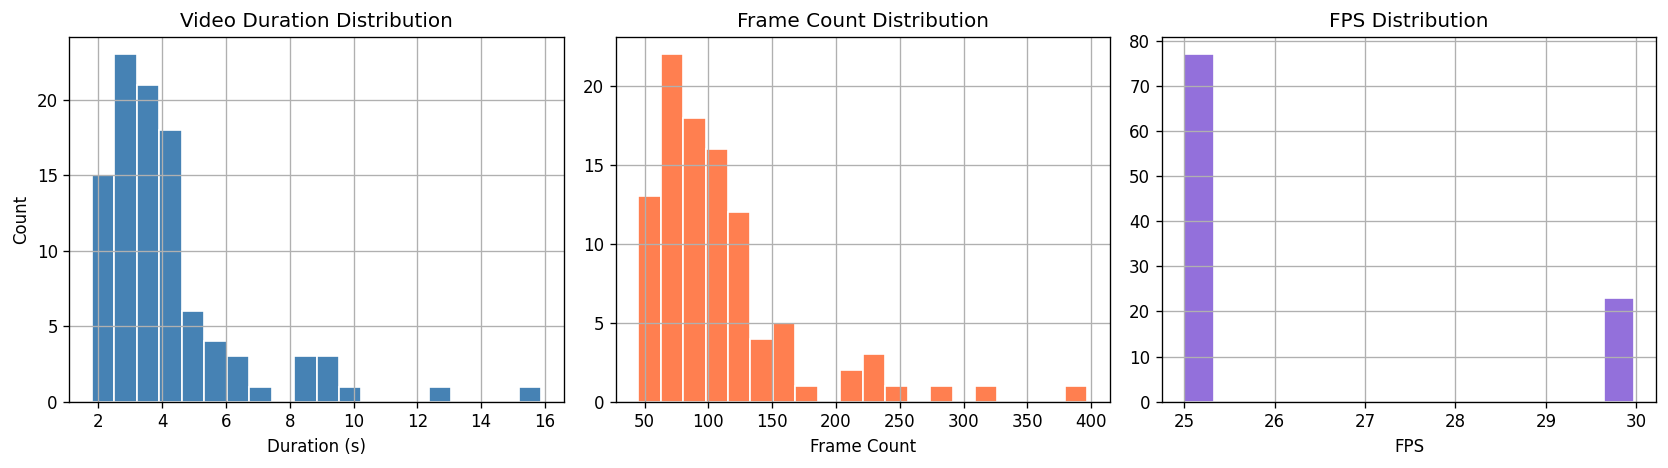


Unique resolutions:
 width  height  count
   640     360    100


In [4]:
fig, axes = plt.subplots(1, 3, figsize=(14, 4))

meta_df["duration_s"].hist(ax=axes[0], bins=20, color="steelblue", edgecolor="white")
axes[0].set_xlabel("Duration (s)")
axes[0].set_ylabel("Count")
axes[0].set_title("Video Duration Distribution")

meta_df["n_frames"].hist(ax=axes[1], bins=20, color="coral", edgecolor="white")
axes[1].set_xlabel("Frame Count")
axes[1].set_title("Frame Count Distribution")

meta_df["fps"].hist(ax=axes[2], bins=15, color="mediumpurple", edgecolor="white")
axes[2].set_xlabel("FPS")
axes[2].set_title("FPS Distribution")

plt.tight_layout()
plt.show()

# Resolution summary
print("\nUnique resolutions:")
print(meta_df.groupby(["width", "height"]).size().reset_index(name="count").to_string(index=False))

## 3. Label Files

Examine the `.npy` label arrays shipped with the dataset.

In [10]:
label_dir = DATA_DIR / "labels"
for npy_file in sorted(label_dir.glob("*.npy")):
    arr = np.load(npy_file, allow_pickle=True)
    print(f"{npy_file.name}: shape={arr.shape}, dtype={arr.dtype}")
    print(f"  Unique values: {np.unique(arr)}")
    print(f"  First 10: {arr.flat[:10]}")
    print()

correct.npy: shape=(50, 150, 66), dtype=float64
  Unique values: [-0.30657297 -0.30471975 -0.29842347 ...  1.14115238  1.14337635
  1.14717591]
  First 10: [0.72996914 0.56077725 0.74594104 0.54692626 0.74696243 0.54494941
 0.74790233 0.54260212 0.74234235 0.5403949 ]

incorrect.npy: shape=(50, 150, 66), dtype=float64
  Unique values: [-0.17678046 -0.17618172 -0.17527001 ...  0.96292019  0.96292067
  0.96293747]
  First 10: [0.7725426  0.57772201 0.78039402 0.56060112 0.78010303 0.55743182
 0.77976078 0.55372506 0.78026831 0.56030625]



## 4. Sample Frames

Display frames at 25%, 50%, and 75% through each of 3 correct and 3 incorrect videos.

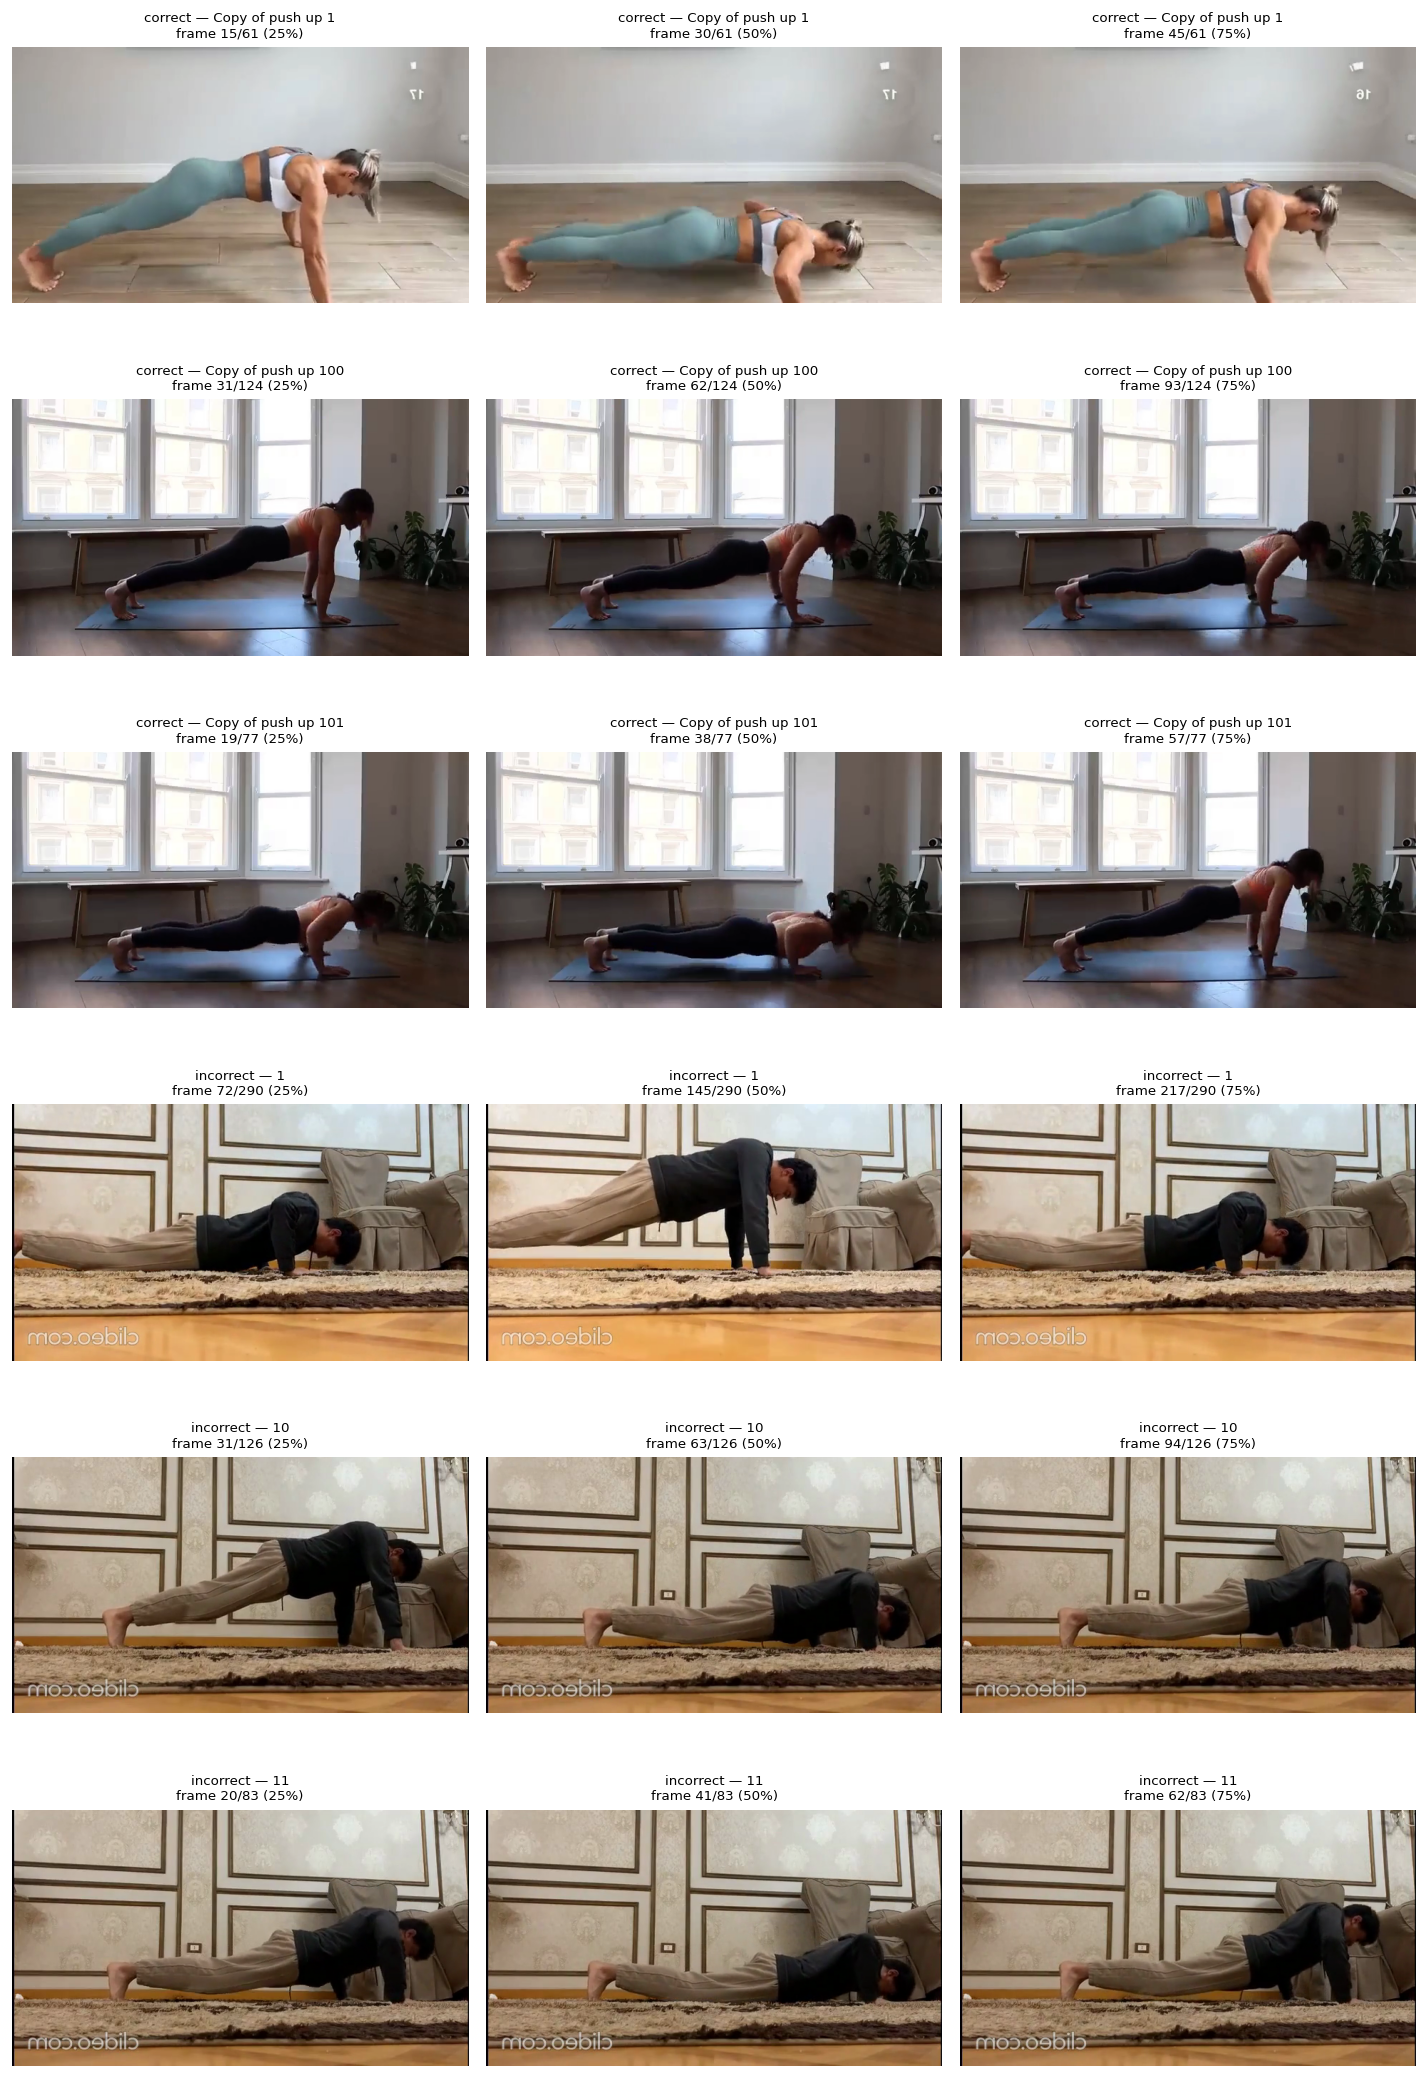

In [11]:
sample_correct = correct_videos[:3]
sample_wrong = wrong_videos[:3]
sample_videos = sample_correct + sample_wrong
sample_labels = ["correct"] * 3 + ["incorrect"] * 3
positions = [0.25, 0.50, 0.75]


fig, axes = plt.subplots(6, 3, figsize=(12, 18))

for row, (vpath, label) in enumerate(zip(sample_videos, sample_labels)):
    cap = cv2.VideoCapture(str(vpath))
    n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    for col, pct in enumerate(positions):
        target_frame = int(n_frames * pct)
        cap.set(cv2.CAP_PROP_POS_FRAMES, target_frame)
        ret, frame = cap.read()
        if ret:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[row, col].imshow(rgb)
        axes[row, col].set_title(f"{label} — {vpath.stem}\nframe {target_frame}/{n_frames} ({int(pct*100)}%)", fontsize=8)
        axes[row, col].axis("off")
    cap.release()

plt.tight_layout()
plt.show()

## 5. Observations (Kaggle Dataset)

**Key findings:**

- The dataset is balanced: 50 correct + 50 incorrect push-up videos.
- Videos are short clips (typically 2-10 seconds each).
- All videos share similar resolution (640x360) and frame rate (~25 FPS).
- "Correct" sequences show proper push-up form; "Wrong" sequences include various common form errors.
- The label `.npy` files contain per-video binary labels matching the directory structure.
- Sample frames confirm the dataset contains single-person push-up recordings from various angles.

## 6. Stress Test Videos — Inventory

Additional videos collected from YouTube to test model robustness under challenging conditions.
These live in `data/raw/stress_test/` organized by challenge type.

In [12]:
STRESS_DIR = Path("../data/raw/stress_test")
CHALLENGE_TYPES = [
    "side_angle", "front_angle", "diagonal", "low_resolution",
    "poor_lighting", "noisy_compressed", "multiple_people",
]

# Inventory
stress_records = []
for challenge in CHALLENGE_TYPES:
    folder = STRESS_DIR / challenge
    if not folder.exists():
        continue
    for ext in ("*.mp4", "*.avi", "*.mov"):
        for vpath in sorted(folder.glob(ext)):
            cap = cv2.VideoCapture(str(vpath))
            fps = cap.get(cv2.CAP_PROP_FPS) or 0
            n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
            w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
            h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
            cap.release()
            stress_records.append({
                "challenge": challenge,
                "file": vpath.name,
                "width": w,
                "height": h,
                "fps": round(fps, 1),
                "n_frames": n_frames,
                "duration_s": round(n_frames / fps, 1) if fps > 0 else 0,
            })

if stress_records:
    stress_meta = pd.DataFrame(stress_records)
    print(f"Stress test videos: {len(stress_meta)} across {stress_meta['challenge'].nunique()} categories\n")

    # Count per category
    cat_counts = stress_meta.groupby("challenge").size().reset_index(name="videos")
    print(cat_counts.to_string(index=False))
    print()
    display(stress_meta)
else:
    print("No stress test videos found.")

Stress test videos: 11 across 5 categories

      challenge  videos
       diagonal       2
    front_angle       2
 low_resolution       2
multiple_people       3
     side_angle       2



challenge                                               file  width  \
0        side_angle                              Push Ups sideview.mp4   1920   
1        side_angle                            Push-up (side view).mp4   1920   
2       front_angle                           Push-up - front view.mp4   1920   
3       front_angle                              Pushup Front View.mp4   1920   
4          diagonal  How to do a Push-Up ｜ Proper Form & Technique ...   1920   
5          diagonal   Most Push-Ups in 1 MINUTE ! ( WORLD RECORD ).mp4   1920   
6    low_resolution                             Push Up Front View.mp4    640   
7    low_resolution                              Push Up Side View.mp4    528   
8   multiple_people  Push-Up contest with Cameron Hanes and Matthew...   1920   
9   multiple_people               TXDPS ＂Kill 22＂ Pushup Challenge.mp4   1920   
10  multiple_people     Women's Murph - 2015 Reebok CrossFit Games.mp4   1920   

    height   fps  n_frames  duration_s  
0     1080  30.0       259         8.6  
1     1080  30.0       314        10.5  
2     1080  24.0       176         7.3  
3     1080  24.0       173         7.2  
4     1080  24.0       325        13.6  
5     1080  55.0       584        10.6  
6      360  30.0       166         5.5  
7      360  30.1       301        10.0  
8     1080  30.0       263         8.8  
9     1080  30.0       449        15.0  
10    1080  30.0       410        13.7

### Stress Test — Metadata Comparison vs Kaggle

dataset        Kaggle (100 videos)        Stress Test (11 videos)
resolutions              [640x360]  [1920x1080, 640x360, 528x360]
fps_range                    25–30                          24–55
duration_range           1.8–15.9s                      5.5–15.0s
mean_duration                 4.2s                          10.1s

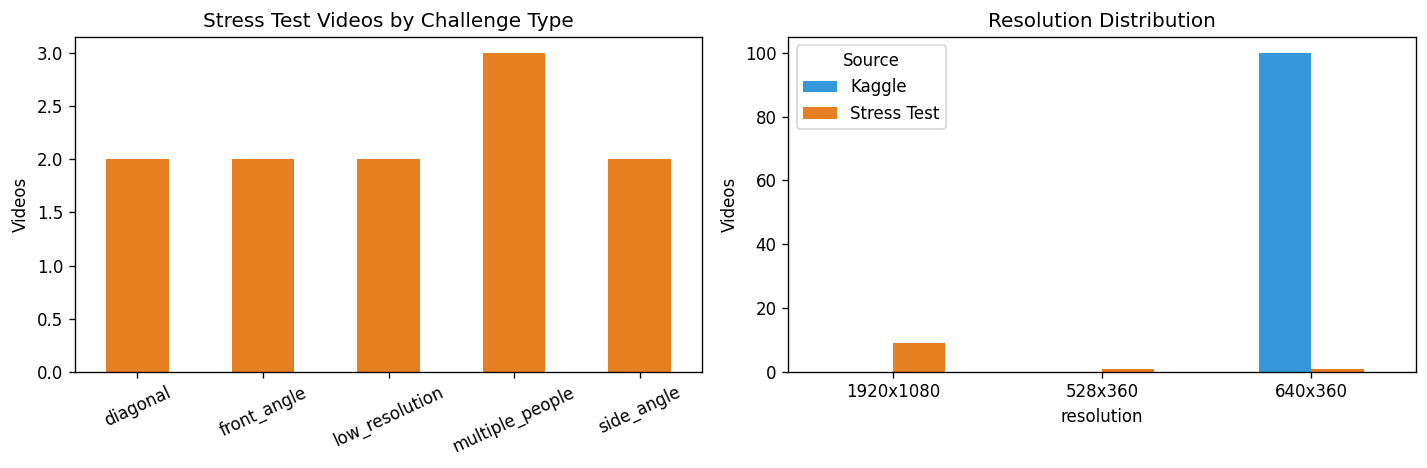

In [13]:
if stress_records:
    # Side-by-side comparison of Kaggle vs stress test metadata
    kaggle_summary = {
        "dataset": "Kaggle (100 videos)",
        "resolutions": meta_df.apply(lambda r: f"{int(r.width)}x{int(r.height)}", axis=1).unique().tolist(),
        "fps_range": f"{meta_df.fps.min():.0f}–{meta_df.fps.max():.0f}",
        "duration_range": f"{meta_df.duration_s.min():.1f}–{meta_df.duration_s.max():.1f}s",
        "mean_duration": f"{meta_df.duration_s.mean():.1f}s",
    }
    stress_summary = {
        "dataset": f"Stress Test ({len(stress_meta)} videos)",
        "resolutions": stress_meta.apply(lambda r: f"{r.width}x{r.height}", axis=1).unique().tolist(),
        "fps_range": f"{stress_meta.fps.min():.0f}–{stress_meta.fps.max():.0f}",
        "duration_range": f"{stress_meta.duration_s.min():.1f}–{stress_meta.duration_s.max():.1f}s",
        "mean_duration": f"{stress_meta.duration_s.mean():.1f}s",
    }

    comp = pd.DataFrame([kaggle_summary, stress_summary]).set_index("dataset")
    display(comp.T)

    # Bar chart: videos per source
    fig, axes = plt.subplots(1, 2, figsize=(12, 4))

    # Category counts for stress test
    cat_counts.plot(kind="bar", x="challenge", y="videos", ax=axes[0],
                    color="#e67e22", legend=False, rot=25)
    axes[0].set_ylabel("Videos")
    axes[0].set_title("Stress Test Videos by Challenge Type")
    axes[0].set_xlabel("")

    # Resolution comparison
    all_res = []
    for _, row in meta_df.iterrows():
        all_res.append({"resolution": f"{int(row.width)}x{int(row.height)}", "source": "Kaggle"})
    for _, row in stress_meta.iterrows():
        all_res.append({"resolution": f"{row.width}x{row.height}", "source": "Stress Test"})
    res_df = pd.DataFrame(all_res)
    res_counts = res_df.groupby(["resolution", "source"]).size().unstack(fill_value=0)
    res_counts.plot(kind="bar", ax=axes[1], color=["#3498db", "#e67e22"], rot=0)
    axes[1].set_ylabel("Videos")
    axes[1].set_title("Resolution Distribution")
    axes[1].legend(title="Source")

    plt.tight_layout()
    plt.show()

### Stress Test — Sample Frames

One frame at 50% from each stress test video.

/var/folders/1q/pcrqby796fnbjgbr9ty_p12m0000gn/T/ipykernel_98936/693864259.py:30: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/1q/pcrqby796fnbjgbr9ty_p12m0000gn/T/ipykernel_98936/693864259.py:30: UserWarning: Glyph 65282 (\N{FULLWIDTH QUOTATION MARK}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/Users/ikhyvicky/CS604/pushup-tracker/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65372 (\N{FULLWIDTH VERTICAL LINE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/Users/ikhyvicky/CS604/pushup-tracker/.venv/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 65282 (\N{FULLWIDTH QUOTATION MARK}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


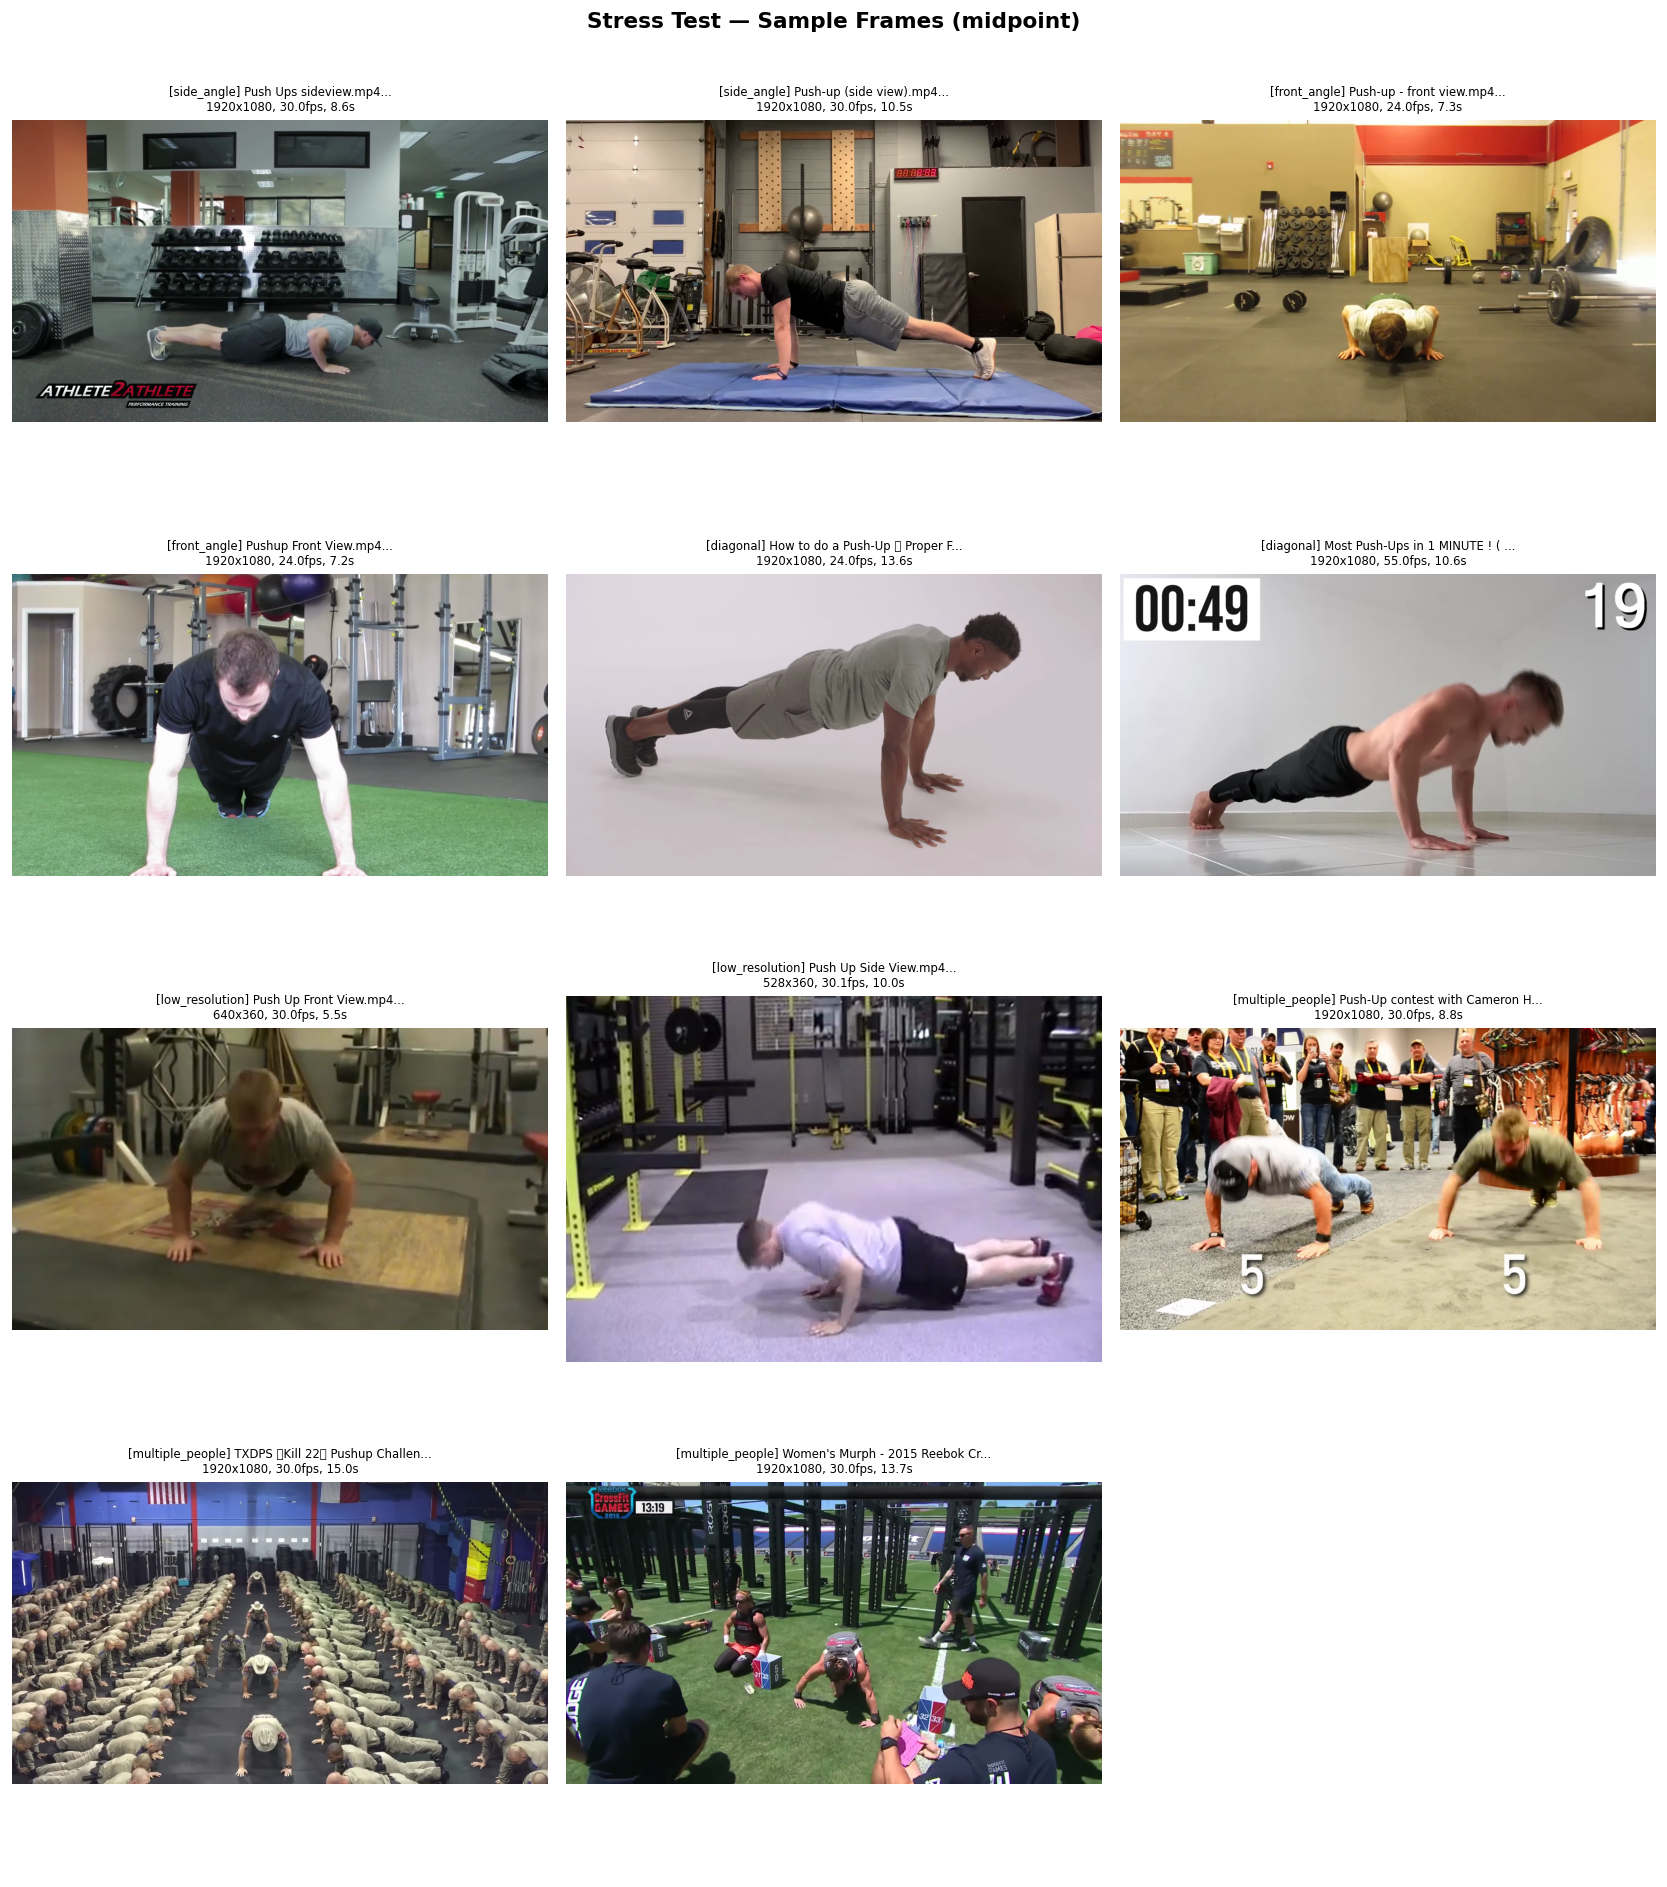

In [14]:
if stress_records:
    n_stress = len(stress_meta)
    cols = 3
    rows = (n_stress + cols - 1) // cols
    fig, axes = plt.subplots(rows, cols, figsize=(14, 4 * rows))
    axes = axes.flatten() if n_stress > cols else [axes] if n_stress == 1 else axes.flatten()

    for i, (_, row) in enumerate(stress_meta.iterrows()):
        vpath = STRESS_DIR / row.challenge / row.file
        cap = cv2.VideoCapture(str(vpath))
        n_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
        cap.set(cv2.CAP_PROP_POS_FRAMES, n_frames // 2)
        ret, frame = cap.read()
        cap.release()

        if ret:
            rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            axes[i].imshow(rgb)
        axes[i].set_title(
            f"[{row.challenge}] {row.file[:30]}...\n{row.width}x{row.height}, {row.fps}fps, {row.duration_s}s",
            fontsize=7,
        )
        axes[i].axis("off")

    # Hide unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.suptitle("Stress Test — Sample Frames (midpoint)", fontsize=13, fontweight="bold")
    plt.tight_layout()
    plt.show()

## 7. Overall Data Summary

| Dataset | Videos | Resolution | FPS | Purpose |
|---------|--------|-----------|-----|---------|
| Kaggle (correct) | 50 | 640x360 | ~25 | Training / benchmarking — good form |
| Kaggle (incorrect) | 50 | 640x360 | ~25 | Training / benchmarking — bad form |
| Stress test | 11 | Mixed (360p–1080p) | 24–55 | Model robustness validation |

The Kaggle dataset is uniform (single resolution, single FPS range, clean indoor footage).
The stress test videos deliberately break these assumptions to reveal model failure modes
before investing in LSTM/transformer training on potentially unreliable keypoints.